In [1]:
%config InlineBackend.figure_format = 'svg'

In [2]:
import genjax
from dataclasses import dataclass
from genjax import dippl
from genjax import gensp
from genjax import select, dirac
import equinox as eqx
import optax
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
from jax import config
import adevjax
from datasets import *
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm

config.update("jax_debug_nans", True)
console = genjax.pretty(show_locals=False)
key = jax.random.PRNGKey(314159)

# Plotting.
sns.set_theme(style="white")

# Data.
train_images, _, _, _ = mnist()
train_images = jnp.where(train_images > 0.5, 1.0, 0.0)


def dataloader(image_array, batch_size):
    dataset_size = len(train_images)
    indices = np.arange(dataset_size)
    while True:
        perm = np.random.permutation(indices)
        start = 0
        end = batch_size
        while end <= dataset_size:
            batch_perm = perm[start:end]
            yield image_array[batch_perm]
            start = end
            end = start + batch_size

I0000 00:00:1696214234.706429   39646 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


## Visualize some of the data examples

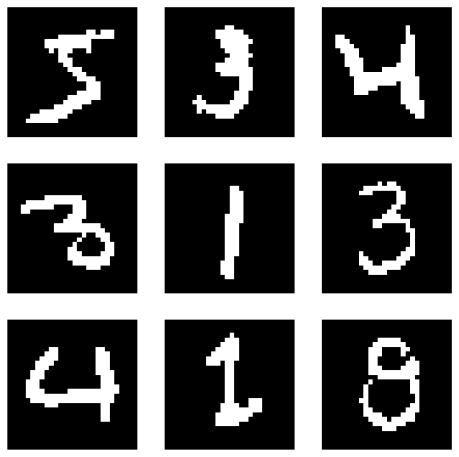

In [3]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))
counter = 0
for (i, j) in itertools.product(range(0, 3), range(0, 3)):
    sub_axis = axs[i, j]
    sub_axis.set_axis_off()
    sub_axis.imshow(train_images[counter].reshape(28, 28) / 255.0, cmap="gray")
    counter += 10

## Gradients using `DIPPL`

In [4]:
@genjax.gen
def decoder_model(decoder):
    latent = dippl.mv_normal_diag_reparam(jnp.zeros(10), jnp.ones(10)) @ "latent"
    image = decoder(latent)
    noisy_image = dippl.mv_normal_diag_reparam(image, jnp.ones(784)) @ "image"


@genjax.gen
def encoder_model(encoder, chm):
    image = chm.get_leaf_value()["image"]
    μ, Σ_diag = encoder(image)
    x = dippl.mv_normal_diag_reparam(μ, jnp.ones_like(μ)) @ "latent"


decoder_model = gensp.choice_map_distribution(
    decoder_model, select("latent", "image"), None
)
encoder_model = gensp.choice_map_distribution(encoder_model, select("latent"), None)

# Define our gradient estimator using our loss language.
def variational_value_and_grad(
    key,
    data,
    encoder,
    decoder,
):
    v_chm = genjax.value_choice_map(genjax.choice_map({"image": data}))

    @dippl.loss
    def vae_loss(encoder, decoder):
        v = dippl.upper(encoder_model)(encoder, v_chm)
        merged = gensp.merge(v, v_chm)
        dippl.lower(decoder_model)(merged, decoder)

    return vae_loss.value_and_grad_estimate(key, (encoder, decoder))


def minibatch_value_and_grad(key, data, encoder, decoder):
    sub_keys = jax.random.split(key, len(data))
    loss, (encoder_grad, decoder_grad) = jax.vmap(
        variational_value_and_grad, in_axes=(0, 0, None, None)
    )(sub_keys, data, encoder, decoder)
    encoder_grad, decoder_grad = jtu.tree_map(
        lambda v: jnp.mean(v, axis=0), (encoder_grad, decoder_grad)
    )
    loss = jnp.mean(loss)
    return loss, (encoder_grad, decoder_grad)

## Encoder/decoder architectures

In [5]:
@dataclass
class EncoderNetwork(genjax.Pytree):
    latent_dim: genjax.typing.Int
    layers: genjax.typing.List

    def flatten(self):
        return (self.layers,), (self.latent_dim,)

    def new(key, latent_dim):
        key, sub_key = jax.random.split(key)
        conv_1 = eqx.nn.Conv2d(
            in_channels=1, out_channels=32, kernel_size=3, stride=(2, 2), key=sub_key
        )
        key, sub_key = jax.random.split(key)
        conv_2 = eqx.nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, stride=(2, 2), key=sub_key
        )
        dense = eqx.nn.Linear(
            in_features=2304, out_features=latent_dim + latent_dim, key=key
        )
        layers = [conv_1, conv_2, dense]
        return EncoderNetwork(latent_dim, layers)

    def __call__(self, v):
        v = v.reshape(1, 28, 28)
        for layer in self.layers[:-1]:
            v = jax.nn.relu(layer(v))
        v = v.flatten()
        v = self.layers[-1](v)  # Dense
        mu = v[0 : self.latent_dim]
        sigma = v[self.latent_dim :]
        return mu, jnp.exp(0.5 * sigma)


@dataclass
class DecoderNetwork(genjax.Pytree):
    layers: genjax.typing.List

    def flatten(self):
        return (self.layers,), ()

    def new(key, latent_dim):
        key, sub_key = jax.random.split(key)
        dense = eqx.nn.Linear(
            in_features=latent_dim, out_features=6 * 6 * 32, key=sub_key
        )
        key, sub_key = jax.random.split(key)
        conv_tr_1 = eqx.nn.ConvTranspose2d(
            in_channels=32, out_channels=64, kernel_size=3, stride=2, key=sub_key
        )
        key, sub_key = jax.random.split(key)
        conv_tr_2 = eqx.nn.ConvTranspose2d(
            in_channels=64, out_channels=32, kernel_size=3, stride=2, key=sub_key
        )
        conv_tr_3 = eqx.nn.ConvTranspose2d(
            in_channels=32, out_channels=1, kernel_size=2, stride=1, key=key
        )
        layers = [dense, conv_tr_1, conv_tr_2, conv_tr_3]
        return DecoderNetwork(layers)

    def __call__(self, v):
        v = jax.nn.relu(self.layers[0](v))
        v = v.reshape(32, 6, 6)
        for layer in self.layers[1:]:
            v = jax.nn.relu(layer(v))
        v = v.reshape(784)
        return v

## Training

In [6]:
key = jax.random.PRNGKey(314159)
learning_rate = 1e-3
iter_data = dataloader(train_images, 32)
key, sub_key = jax.random.split(key)
encoder_net = EncoderNetwork.new(sub_key, 10)
key, sub_key = jax.random.split(key)
decoder_net = DecoderNetwork.new(sub_key, 10)
steps = 100000


@jax.jit
def make_step(key, encoder_net, decoder_net, data, opt_state):
    loss, grads = minibatch_value_and_grad(key, data, encoder_net, decoder_net)
    grads = jtu.tree_map(lambda v: -v, grads)
    updates, opt_state = optim.update(grads, opt_state)
    encoder_net, decoder_net = eqx.apply_updates((encoder_net, decoder_net), updates)
    mean_grad = jnp.mean(jnp.array(jtu.tree_leaves(jtu.tree_map(jnp.mean, grads))))
    return loss, (encoder_net, decoder_net), opt_state, mean_grad


optim = optax.adam(learning_rate)
opt_state = optim.init((encoder_net, decoder_net))
for step, image_batch in tqdm(zip(range(steps), iter_data)):
    key, sub_key = jax.random.split(key)
    loss, (encoder_net, decoder_net), opt_state, mean_grad = make_step(
        sub_key, encoder_net, decoder_net, image_batch, opt_state
    )
    loss = loss.item()
    if step % 1000 == 0:
        print(loss)

33it [00:01, 23.80it/s]

-766.9027099609375


1049it [00:05, 309.16it/s]

-750.2811279296875


2044it [00:08, 290.31it/s]

-748.7854614257812


3039it [00:12, 310.30it/s]

-750.8598022460938


4046it [00:15, 310.80it/s]

-751.12548828125


5049it [00:18, 304.40it/s]

-747.985595703125


6059it [00:22, 308.65it/s]

-750.7094116210938


7037it [00:25, 308.87it/s]

-750.92822265625


8047it [00:28, 304.65it/s]

-751.9044799804688


9040it [00:31, 301.70it/s]

-750.094482421875


10037it [00:35, 311.04it/s]

-749.3777465820312


11044it [00:38, 311.15it/s]

-750.8597412109375


12033it [00:41, 311.02it/s]

-750.934326171875


13033it [00:44, 292.60it/s]

-748.351318359375


14034it [00:48, 305.20it/s]

-748.467529296875


15046it [00:51, 319.11it/s]

-751.0203857421875


16049it [00:54, 300.92it/s]

-749.3019409179688


17040it [00:57, 301.08it/s]

-751.029052734375


18045it [01:01, 305.98it/s]

-749.7322998046875


19032it [01:04, 296.08it/s]

-751.053466796875


20035it [01:07, 301.99it/s]

-749.9913330078125


21060it [01:11, 300.55it/s]

-749.4868774414062


22045it [01:14, 307.21it/s]

-749.78466796875


23038it [01:18, 294.57it/s]

-750.5079345703125


24031it [01:21, 305.94it/s]

-749.75048828125


25042it [01:24, 293.25it/s]

-749.5634765625


26048it [01:28, 284.41it/s]

-748.5155029296875


27035it [01:31, 299.05it/s]

-750.3679809570312


28034it [01:35, 292.49it/s]

-749.639404296875


29045it [01:38, 304.39it/s]

-750.313232421875


30039it [01:41, 300.91it/s]

-749.6553955078125


31058it [01:45, 297.32it/s]

-748.726318359375


32056it [01:48, 290.11it/s]

-749.6292724609375


33037it [01:52, 304.29it/s]

-749.9440307617188


34044it [01:55, 278.92it/s]

-749.7764892578125


35042it [01:59, 296.13it/s]

-749.2044677734375


36031it [02:02, 284.75it/s]

-752.10400390625


37042it [02:06, 282.80it/s]

-748.4951782226562


38052it [02:09, 295.34it/s]

-750.4258422851562


39051it [02:13, 279.85it/s]

-752.7071533203125


40033it [02:16, 283.05it/s]

-750.1702880859375


41038it [02:20, 295.63it/s]

-747.4046020507812


42053it [02:23, 286.16it/s]

-748.9906005859375


43040it [02:27, 277.34it/s]

-750.3197021484375


44052it [02:30, 283.64it/s]

-750.857666015625


45044it [02:34, 275.89it/s]

-751.4603271484375


46048it [02:37, 279.35it/s]

-750.0980224609375


47035it [02:41, 290.86it/s]

-749.4368896484375


48047it [02:44, 284.88it/s]

-749.544677734375


49047it [02:47, 302.81it/s]

-747.9639892578125


50046it [02:51, 275.05it/s]

-749.00439453125


51045it [02:54, 275.76it/s]

-752.4029541015625


52047it [02:58, 283.13it/s]

-750.1043701171875


53033it [03:01, 290.56it/s]

-750.6962890625


54030it [03:05, 276.73it/s]

-751.4345703125


55045it [03:09, 287.54it/s]

-749.5775146484375


56037it [03:12, 289.34it/s]

-750.888671875


57030it [03:15, 280.34it/s]

-748.945556640625


58051it [03:19, 296.53it/s]

-751.0431518554688


59042it [03:22, 289.74it/s]

-749.8555908203125


60032it [03:26, 270.49it/s]

-751.377197265625


61051it [03:30, 293.78it/s]

-749.730712890625


62040it [03:33, 294.90it/s]

-748.5234375


63045it [03:37, 277.49it/s]

-745.8780517578125


64042it [03:40, 291.46it/s]

-748.3682861328125


65050it [03:43, 295.41it/s]

-748.8998413085938


66056it [03:47, 274.67it/s]

-748.98974609375


67044it [03:50, 286.52it/s]

-748.4295654296875


68034it [03:54, 290.42it/s]

-748.39453125


69035it [03:57, 278.95it/s]

-749.6235961914062


70039it [04:01, 296.19it/s]

-747.9100341796875


71043it [04:04, 281.27it/s]

-749.0638427734375


72045it [04:08, 277.13it/s]

-752.1213989257812


73049it [04:12, 289.81it/s]

-747.8587036132812


74029it [04:15, 279.23it/s]

-751.4729614257812


75038it [04:19, 278.27it/s]

-749.173828125


76032it [04:22, 295.33it/s]

-750.7025756835938


77047it [04:25, 276.05it/s]

-747.417236328125


78049it [04:29, 276.56it/s]

-748.999267578125


79059it [04:33, 287.87it/s]

-748.850830078125


80035it [04:36, 280.52it/s]

-749.9619140625


81046it [04:40, 281.22it/s]

-751.0133666992188


82050it [04:43, 285.71it/s]

-750.3551635742188


83043it [04:47, 283.34it/s]

-749.251708984375


84032it [04:50, 296.15it/s]

-749.4742431640625


85048it [04:54, 291.13it/s]

-748.655517578125


86040it [04:57, 280.33it/s]

-749.6029052734375


87050it [05:01, 289.86it/s]

-749.7935791015625


88046it [05:04, 290.07it/s]

-751.3164672851562


89055it [05:08, 274.95it/s]

-748.699462890625


90035it [05:11, 276.36it/s]

-749.85595703125


91052it [05:15, 297.06it/s]

-750.280029296875


92033it [05:18, 279.28it/s]

-748.8114013671875


93046it [05:22, 293.24it/s]

-750.3447265625


94043it [05:25, 291.73it/s]

-747.5286865234375


95044it [05:29, 276.88it/s]

-748.0958251953125


96041it [05:32, 292.83it/s]

-749.0906982421875


97051it [05:35, 283.17it/s]

-749.7512817382812


98039it [05:39, 280.21it/s]

-750.2879028320312


99051it [05:42, 297.29it/s]

-749.0966186523438


100000it [05:46, 288.79it/s]


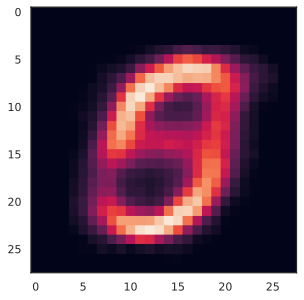

In [46]:
key, sub_key = jax.random.split(key)
latent = genjax.tfp_mv_normal_diag.sample(sub_key, jnp.zeros(10), jnp.ones(10))
plt.imshow(decoder_net(latent).reshape(28, 28))